<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/MRtoCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MR to CT

## Step 1: Setup the Environment

In [1]:
# Install required libraries
!pip install datasets

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

## Step 2: Load and Preprocess the MRI Dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

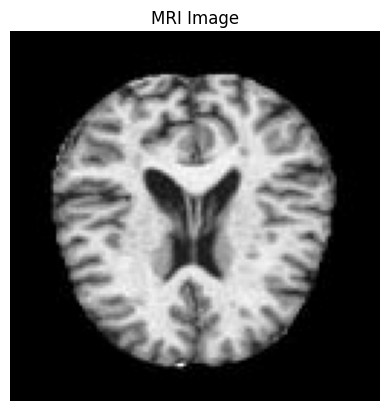

In [2]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (as per the paper's input size)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class for MRI only
class MRIDataset(Dataset):
    def __init__(self, mri_dataset, transform=None):
        self.mri_dataset = mri_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']  # Adjust key if needed
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        return mri_image

# Create dataset and dataloader
dataset = MRIDataset(mri_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img = dataset[0]
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.show()

## Step 3: Define the cGAN Generator and Discriminator

In [3]:
# Residual Block (same as in the paper)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# cGAN Generator (MRI -> CT)
class cGANGenerator(nn.Module):
    def __init__(self):
        super(cGANGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(9)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# cGAN Discriminator
class cGANDiscriminator(nn.Module):
    def __init__(self):
        super(cGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Input: MRI + Generated CT
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, mri, ct):
        x = torch.cat([mri, ct], dim=1)  # Concatenate MRI and CT along channel dimension
        return self.model(x)

# Initialize models
G = cGANGenerator().to(device)
D = cGANDiscriminator().to(device)

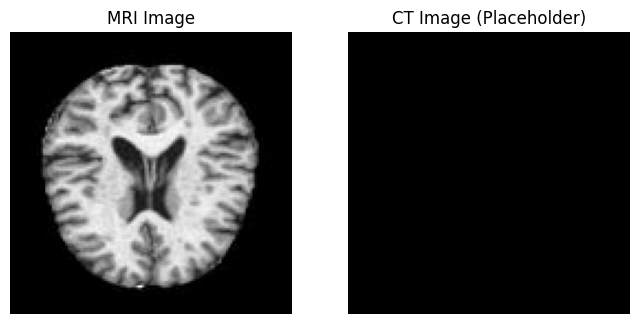

In [10]:
# Load the MRI dataset
mri_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (as per the paper's input size)
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (grayscale, so 1 channel)
])

# Custom Dataset class for MRI (and placeholder for CT)
class ImageDataset(Dataset):
    def __init__(self, mri_dataset, ct_dataset=None, transform=None):
        self.mri_dataset = mri_dataset
        self.ct_dataset = ct_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mri_dataset)

    def __getitem__(self, idx):
        mri_image = self.mri_dataset[idx]['image']  # Adjust key if needed
        if not isinstance(mri_image, Image.Image):
            mri_image = Image.fromarray(np.array(mri_image))

        if self.transform:
            mri_image = self.transform(mri_image)

        # Placeholder for CT image
        if self.ct_dataset:
            ct_image = self.ct_dataset[idx]['image']  # Adjust key if needed
            if not isinstance(ct_image, Image.Image):
                ct_image = Image.fromarray(np.array(ct_image))
            if self.transform:
                ct_image = self.transform(ct_image)
        else:
            # Without CT data, we return a placeholder (zeros)
            ct_image = torch.zeros_like(mri_image)

        return mri_image, ct_image

# Create dataset instance (CT dataset is a placeholder for now)
dataset = ImageDataset(mri_dataset, ct_dataset=None, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize a sample
mri_img, ct_img = dataset[0]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(mri_img.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ct_img.squeeze(), cmap='gray')
plt.title("CT Image (Placeholder)")
plt.axis('off')
plt.show()

## Step 3: Define the Generator

In [11]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(9)])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# Initialize Generators
G_MRI_to_CT = Generator().to(device)
G_CT_to_MRI = Generator().to(device)

## Step 4: Define the Discriminators

In [12]:
# Discriminator (both Appearance and Structural)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize Discriminators
D_MRI = Discriminator().to(device)  # For MRI domain
D_CT = Discriminator().to(device)   # For CT domain

## Step 5: Define Loss Functions and Optimizers

In [13]:
# Loss functions
adversarial_loss = nn.BCELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(
    list(G_MRI_to_CT.parameters()) + list(G_CT_to_MRI.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_MRI = optim.Adam(D_MRI.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_CT = optim.Adam(D_CT.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels for adversarial loss
real_label = torch.ones((4, 1, 8, 8)).to(device)  # Adjust size based on output
fake_label = torch.zeros((4, 1, 8, 8)).to(device)

## Step 6: Training Loop (With Placeholder)

In [1]:
# Training Loop
num_epochs = 10  # Adjust as needed
lambda_cycle = 10.0
lambda_identity = 5.0

for epoch in range(num_epochs):
    for i, (mri_images, ct_images) in enumerate(dataloader):
        mri_images = mri_images.to(device)
        ct_images = ct_images.to(device)

        # Train Discriminators
        optimizer_D_MRI.zero_grad()
        optimizer_D_CT.zero_grad()

        # Real images
        real_mri = D_MRI(mri_images)
        real_ct = D_CT(ct_images)  # This will fail because ct_images are placeholders (zeros)
        loss_D_MRI_real = adversarial_loss(real_mri, real_label)
        loss_D_CT_real = adversarial_loss(real_ct, real_label)

        # Fake images
        fake_ct = G_MRI_to_CT(mri_images)
        fake_mri = G_CT_to_MRI(ct_images)  # This will fail due to lack of real CT data
        fake_mri_pred = D_MRI(fake_mri.detach())
        fake_ct_pred = D_CT(fake_ct.detach())
        loss_D_MRI_fake = adversarial_loss(fake_mri_pred, fake_label)
        loss_D_CT_fake = adversarial_loss(fake_ct_pred, fake_label)

        # Total Discriminator Loss
        loss_D_MRI = (loss_D_MRI_real + loss_D_MRI_fake) * 0.5
        loss_D_CT = (loss_D_CT_real + loss_D_CT_fake) * 0.5
        loss_D_MRI.backward()
        loss_D_CT.backward()
        optimizer_D_MRI.step()
        optimizer_D_CT.step()

        # Train Generators
        optimizer_G.zero_grad()

        # Adversarial Loss
        fake_ct = G_MRI_to_CT(mri_images)
        fake_mri = G_CT_to_MRI(ct_images)  # This will fail
        fake_ct_pred = D_CT(fake_ct)
        fake_mri_pred = D_MRI(fake_mri)
        loss_G_MRI_to_CT = adversarial_loss(fake_ct_pred, real_label)
        loss_G_CT_to_MRI = adversarial_loss(fake_mri_pred, real_label)

        # Cycle Consistency Loss
        cycle_mri = G_CT_to_MRI(fake_ct)
        cycle_ct = G_MRI_to_CT(fake_mri)
        loss_cycle_MRI = cycle_loss(cycle_mri, mri_images)
        loss_cycle_CT = cycle_loss(cycle_ct, ct_images)  # This will fail

        # Identity Loss
        identity_mri = G_CT_to_MRI(mri_images)
        identity_ct = G_MRI_to_CT(ct_images)  # This will fail
        loss_identity_MRI = identity_loss(identity_mri, mri_images)
        loss_identity_CT = identity_loss(identity_ct, ct_images)

        # Total Generator Loss
        loss_G = (
            loss_G_MRI_to_CT +
            loss_G_CT_to_MRI +
            lambda_cycle * (loss_cycle_MRI + loss_cycle_CT) +
            lambda_identity * (loss_identity_MRI + loss_identity_CT)
        )
        loss_G.backward()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D: {loss_D_MRI.item() + loss_D_CT.item():.4f} "
                  f"Loss_G: {loss_G.item():.4f}")

    # Save models
    torch.save(G_MRI_to_CT.state_dict(), f'G_MRI_to_CT_epoch_{epoch+1}.pth')
    torch.save(G_CT_to_MRI.state_dict(), f'G_CT_to_MRI_epoch_{epoch+1}.pth')

NameError: name 'dataloader' is not defined